In [1]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/fracture_detection/MURA-v1.1.zip"
extract_path = "/content/"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


Files extracted to: /content/


In [2]:
!rm -rf /content/__MACOSX
!rm -rf /content/sample_data

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
train_paths = pd.read_csv("MURA-v1.1/train_image_paths.csv", header=None, names=["image_path"])
augmented_paths = pd.read_csv("MURA-v1.1/augmented_image_paths.csv", header=None, names=["image_path"])
train_labels = pd.read_csv("MURA-v1.1/train_labeled_studies.csv", header=None, names=["directory_path", "label"])
augmented_labels = pd.read_csv("MURA-v1.1/augmented_labeled_studies.csv", header=None, names=["directory_path", "label"])

In [5]:
merged_image_paths = pd.concat([train_paths, augmented_paths], ignore_index=True)
merged_image_paths.to_csv("merged_image_paths.csv", index=False, header=False)
merged_labeled_studies = pd.concat([train_labels, augmented_labels], ignore_index=True)
merged_labeled_studies.to_csv("merged_labeled_studies.csv", index=False, header=False)

In [6]:
image_paths = pd.read_csv("merged_image_paths.csv", header=None, names=["image_path"])
study_labels = pd.read_csv("merged_labeled_studies.csv", header=None, names=["directory_path", "label"])

In [7]:
study_labels['directory_path'] = study_labels['directory_path'].str.rstrip('/')
label_mapping = study_labels.set_index('directory_path')['label'].astype(int).to_dict()

In [8]:
def get_study_directory(image_path):
    """Extract study directory from image path"""
    return os.path.dirname(image_path).rstrip('/')

image_paths['study_dir'] = image_paths['image_path'].apply(get_study_directory)
image_paths['label'] = image_paths['study_dir'].map(label_mapping)

In [9]:
print("Unique studies:", len(label_mapping))
print("Label distribution:\n", image_paths['label'].value_counts())

Unique studies: 26914
Label distribution:
 label
0.0    43870
1.0    29746
Name: count, dtype: int64


In [10]:
def create_generator(df):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    ).flow_from_dataframe(
        dataframe=df,
        x_col="image_path",
        y_col="label",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw"
    )

In [11]:
skf = StratifiedKFold(n_splits=5)
results = []

In [13]:
nan_count = image_paths['label'].isna().sum()
print(f"Found {nan_count} images with missing labels")

print("Images with missing labels:")
print(image_paths[image_paths['label'].isna()].head())

Found 1 images with missing labels
Images with missing labels:
      image_path study_dir  label
36808       path              NaN


In [14]:
image_paths = image_paths.dropna(subset=['label'])

In [17]:
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, image_paths['label'])):
    print(f"\nFold {fold+1}/5")

    model = models.Sequential([
        ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    train_df = image_paths.iloc[train_idx]
    val_df = image_paths.iloc[val_idx]

    history = model.fit(
        create_generator(train_df),
        validation_data=create_generator(val_df),
        epochs=10,
        verbose=1
    )

    y_true = val_df['label'].values
    y_pred = (model.predict(create_generator(val_df)) > 0.5).astype(int)

    results.append({
        'fold': fold+1,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    })

    if fold == 0 or results[-1]['f1'] > max(r['f1'] for r in results[:-1]):
        model.save('best_model.h5')


Fold 1/5
Found 58892 validated image filenames.
Found 14724 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 739s 371ms/step - accuracy: 0.5972 - loss: 0.7268 - val_accuracy: 0.6239 - val_loss: 0.6794
Epoch 2/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 647s 351ms/step - accuracy: 0.6599 - loss: 0.6243 - val_accuracy: 0.5839 - val_loss: 0.6912
Epoch 3/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 641s 348ms/step - accuracy: 0.6921 - loss: 0.5862 - val_accuracy: 0.4188 - val_loss: 1.8385
Epoch 4/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 658s 357ms/step - accuracy: 0.7024 - loss: 0.5733 - val_accuracy: 0.6727 - val_loss: 0.6004
Epoch 5/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 691s 362ms/step - accuracy: 0.7163 - loss: 0.5588 - val_accuracy: 0.6656 - val_loss: 0.6947
Epoch 6/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 686s 365ms/step - accuracy: 0.7268 - loss: 0.5419 - val_accuracy: 0.6675 - val_loss: 0.6094
Epoch 7/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 667s 362ms/step - accuracy: 0.7353 - loss: 0.5289 - val_accuracy: 0.6985 - val_loss: 0.5948
Epoch 8/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 671s 365ms/step - ac


Fold 2/5
Found 58893 validated image filenames.
Found 14723 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 757s 381ms/step - accuracy: 0.5939 - loss: 0.7068 - val_accuracy: 0.6433 - val_loss: 0.8282
Epoch 2/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 692s 376ms/step - accuracy: 0.6407 - loss: 0.6397 - val_accuracy: 0.6825 - val_loss: 0.6450
Epoch 3/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 688s 373ms/step - accuracy: 0.6576 - loss: 0.6221 - val_accuracy: 0.6501 - val_loss: 0.6200
Epoch 4/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 737s 371ms/step - accuracy: 0.6777 - loss: 0.5957 - val_accuracy: 0.7116 - val_loss: 0.5784
Epoch 5/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 745s 405ms/step - accuracy: 0.6919 - loss: 0.5807 - val_accuracy: 0.7323 - val_loss: 0.5339
Epoch 6/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 682s 370ms/step - accuracy: 0.7098 - loss: 0.5626 - val_accuracy: 0.7576 - val_loss: 0.5328
Epoch 7/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 683s 371ms/step - accuracy: 0.7246 - loss: 0.5470 - val_accuracy: 0.7494 - val_loss: 0.5164
Epoch 8/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 757s 379ms/step - ac


Fold 3/5
Found 58893 validated image filenames.
Found 14723 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 764s 384ms/step - accuracy: 0.6303 - loss: 0.6863 - val_accuracy: 0.6065 - val_loss: 0.6706
Epoch 2/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 679s 369ms/step - accuracy: 0.6824 - loss: 0.5935 - val_accuracy: 0.6616 - val_loss: 0.6801
Epoch 3/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 681s 370ms/step - accuracy: 0.7114 - loss: 0.5623 - val_accuracy: 0.6547 - val_loss: 0.6236
Epoch 4/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 699s 380ms/step - accuracy: 0.7306 - loss: 0.5382 - val_accuracy: 0.6427 - val_loss: 0.6517
Epoch 5/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 696s 378ms/step - accuracy: 0.7441 - loss: 0.5216 - val_accuracy: 0.6692 - val_loss: 0.6521
Epoch 6/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 695s 377ms/step - accuracy: 0.7525 - loss: 0.5081 - val_accuracy: 0.6153 - val_loss: 0.7016
Epoch 7/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 677s 367ms/step - accuracy: 0.7627 - loss: 0.4929 - val_accuracy: 0.6814 - val_loss: 0.6766
Epoch 8/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 695s 377ms/step - ac

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 776s 390ms/step - accuracy: 0.5869 - loss: 0.7087 - val_accuracy: 0.5932 - val_loss: 0.6845
Epoch 2/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 703s 382ms/step - accuracy: 0.6068 - loss: 0.6601 - val_accuracy: 0.5913 - val_loss: 0.6924
Epoch 3/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 706s 383ms/step - accuracy: 0.6499 - loss: 0.6301 - val_accuracy: 0.6052 - val_loss: 0.6865
Epoch 4/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 717s 389ms/step - accuracy: 0.6785 - loss: 0.6035 - val_accuracy: 0.5338 - val_loss: 1.2459
Epoch 5/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 696s 378ms/step - accuracy: 0.6932 - loss: 0.5863 - val_accuracy: 0.6463 - val_loss: 0.6345
Epoch 6/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 765s 391ms/step - accuracy: 0.7098 - loss: 0.5666 - val_accuracy: 0.6666 - val_loss: 0.6031
Epoch 7/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 728s 395ms/step - accuracy: 0.7222 - loss: 0.5503 - val_accuracy: 0.5068 - val_loss: 1.1461
Epoch 8/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 738s 393ms/step - ac


Fold 5/5
Found 58893 validated image filenames.
Found 14723 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 797s 401ms/step - accuracy: 0.5925 - loss: 0.7059 - val_accuracy: 0.5169 - val_loss: 0.7016
Epoch 2/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 770s 395ms/step - accuracy: 0.6050 - loss: 0.6493 - val_accuracy: 0.5980 - val_loss: 0.7076
Epoch 3/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 743s 404ms/step - accuracy: 0.6615 - loss: 0.6145 - val_accuracy: 0.6500 - val_loss: 0.6381
Epoch 4/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 742s 403ms/step - accuracy: 0.6909 - loss: 0.5834 - val_accuracy: 0.6221 - val_loss: 0.8161
Epoch 5/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 721s 392ms/step - accuracy: 0.7106 - loss: 0.5610 - val_accuracy: 0.5614 - val_loss: 0.6570
Epoch 6/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 724s 393ms/step - accuracy: 0.7239 - loss: 0.5470 - val_accuracy: 0.6464 - val_loss: 0.6938
Epoch 7/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 802s 435ms/step - accuracy: 0.7337 - loss: 0.5306 - val_accuracy: 0.6696 - val_loss: 0.6518
Epoch 8/10
1841/1841 ━━━━━━━━━━━━━━━━━━━━ 753s 409ms/step - ac

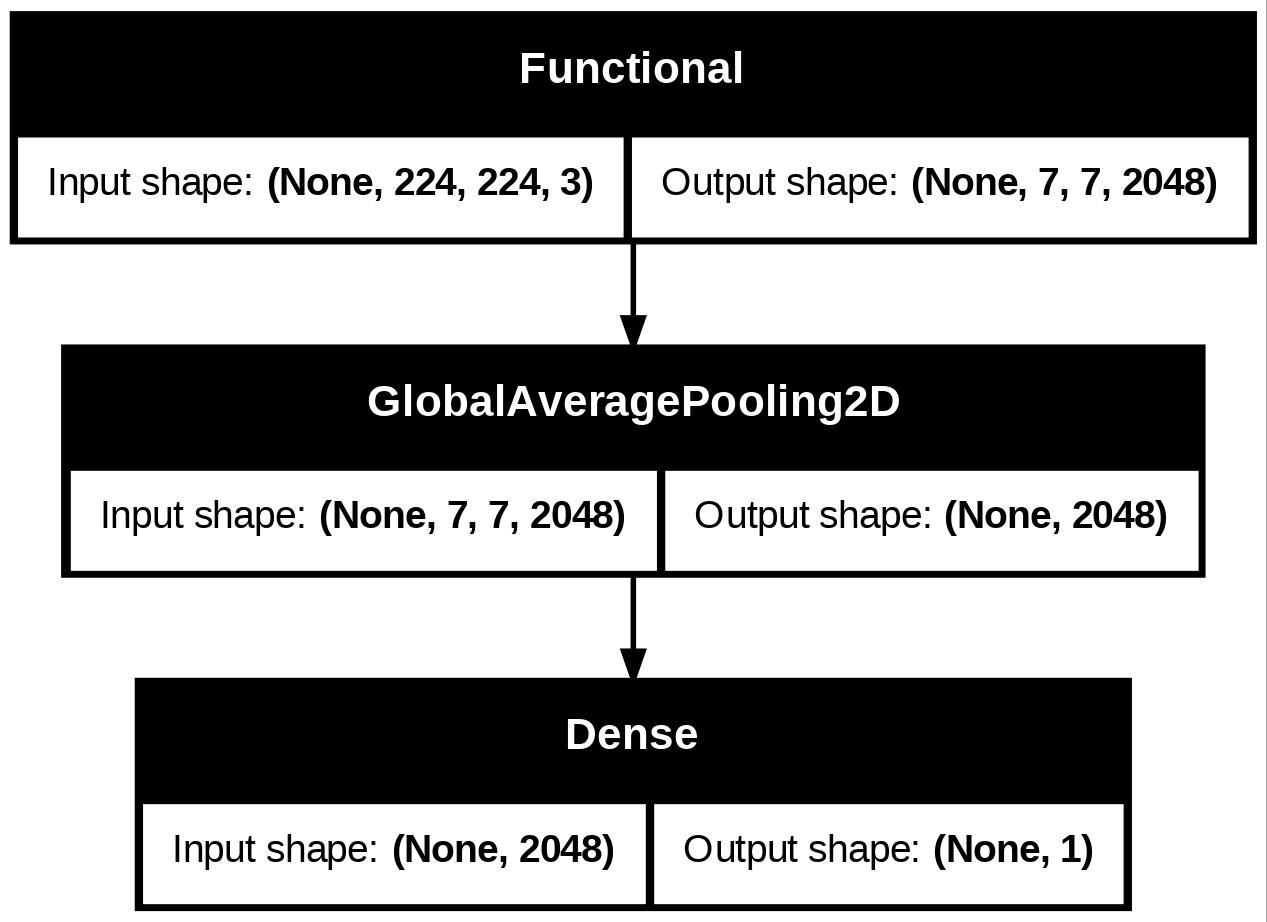

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='Network.jpg', show_shapes=True)